# Time-Series analysis Project: E-sports membership subscription

In this project, I aim to take an analysis to the monthly member subscriptions to a popular E-sports game to make both short-term(3 months) and long-term(2 years) forecasts. The data comes in the form of monthly members subscriptions (in millions) for the past 5 years and no data is missing.

The task is to first inspect the data by plotting it. See if there is a need to apply time differencing. Then fit a time series model to it.

First, I am plotting the data to take a first look on it:

# Data cleaning

In [1]:
#read the data
ts_data <- read.csv(file = 'hist.csv')

str(ts_data)

'data.frame':	60 obs. of  1 variable:
 $ x: num  4.83 6.1 6.47 5.65 6.9 ...


It looks like there are only 1 column for the the data set, which is not expected since time series data usually includes a time/date. But this does not border me because all we need to know is the numeric column.

In [2]:
# check missing value
sum(is.na(ts_data))

[1] 0

Good, we have no missing data, and the column is in the right type. We can now start our analysis.

# EDA

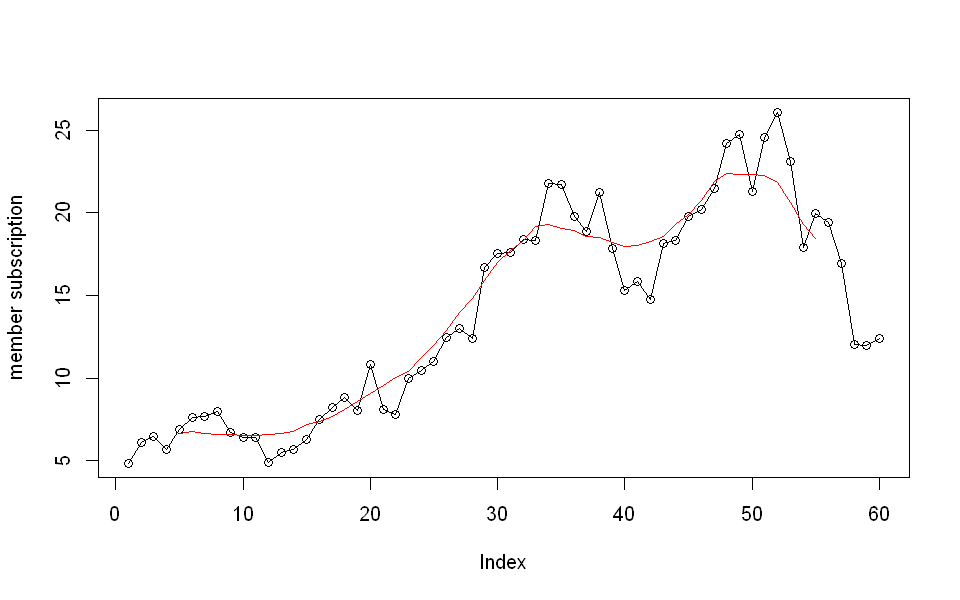

In [3]:
#take the data of member subscription
mem_sub <- ts_data$x

options(repr.plot.width=8, repr.plot.height=5)

#plot the data
plot(mem_sub, type = 'o', ylab = 'member subscription')


# smoothing curve to check if the variance is stationary.
ma10<-filter(mem_sub,sides=2,rep(1,10)/10); lines(ma10, col = 'red'); lines(ma10, col = 'red')

It looks like the variance ios not too stationary and the data is nonlinear. I will first take a log of the data to lower the fluctuations of variance, whcih is a standard proceedure when working with fluctuating data.

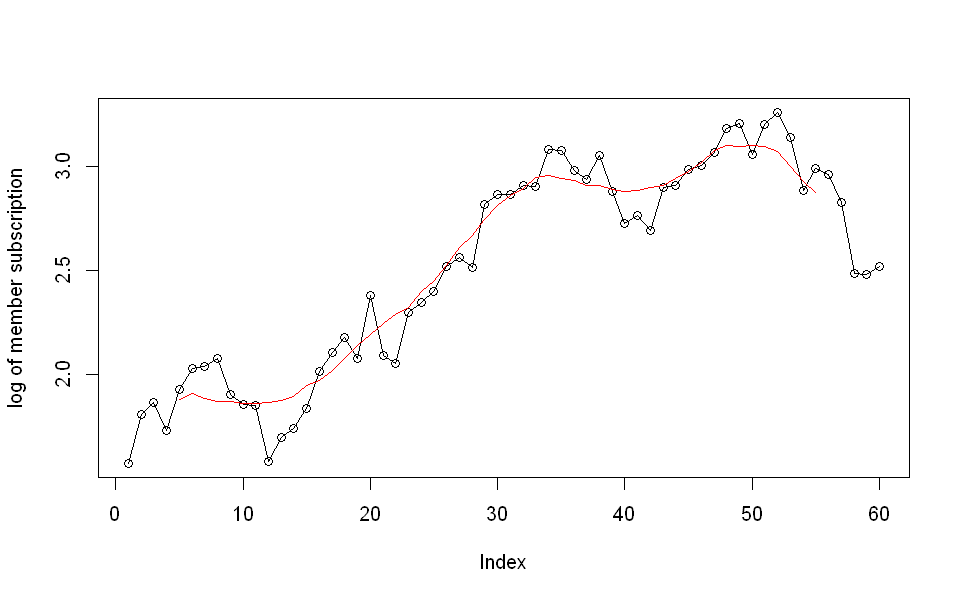

In [4]:
#log the data
y <- log(mem_sub)

options(repr.plot.width=8, repr.plot.height=5)

#plot the logged data
plot(y, type = 'o', ylab = 'log of member subscription')

# smoothing curve to check if the variance is stationary.
ma10<-filter(y,sides=2,rep(1,10)/10); lines(ma10, col = 'red'); lines(ma10, col = 'red')

The data seems closer to each other but the trend is still non-linear. Next we take a look at the ACF and PACF plots to make further inspection:

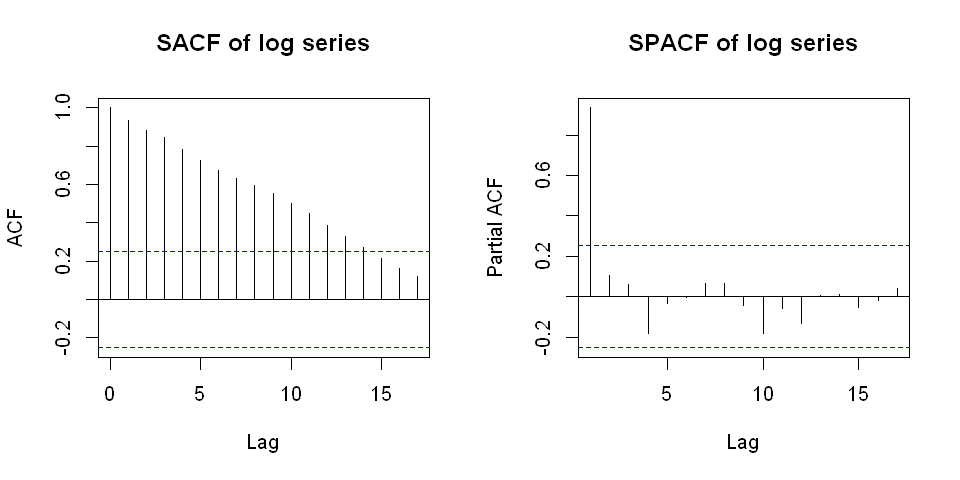

In [5]:
par(mfrow = c(1,2))
options(repr.plot.width=8, repr.plot.height=4)
acf(y, main = 'SACF of log series')
pacf(y, main = 'SPACF of log series')

We can see that the SACF decays slowly and the PACF decays rapidly. This suggests that there might be a possible unit root, and differencing might be needed. We will now take a Augmented Dickey-Fuller Test to see if a differencing is needed for further analysis. Our hypnothesis is as follows:


\begin{split}
H_0 & : \phi = 1 \text{ (Differencing needed)}\\
H_1 & : \phi \neq 1 \text{ (Differencing not needed)}
\end{split}


In [6]:
library(tseries)

#Augmented Dickey-Fuller test
adf.test(y)

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



	Augmented Dickey-Fuller Test

data:  y
Dickey-Fuller = -0.85898, Lag order = 3, p-value = 0.9514
alternative hypothesis: stationary


The test shows that the p-value of $H_0$ is $0.9514>0.05$. It suggests that we fail to reject $H_0$ at $5\%$ significance level. Therefore, we conclude that unit root exists in the series. Lets take a look at the plot, SACF and SPACF of the differenced log series:

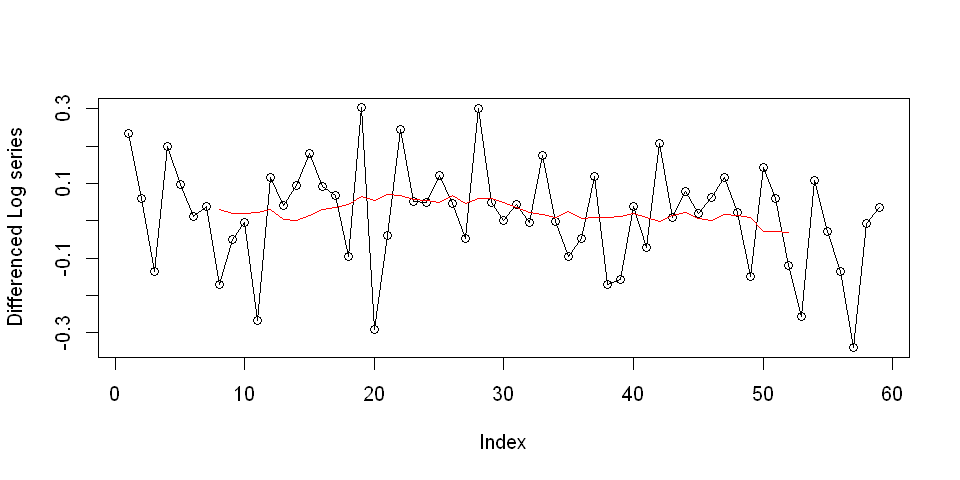

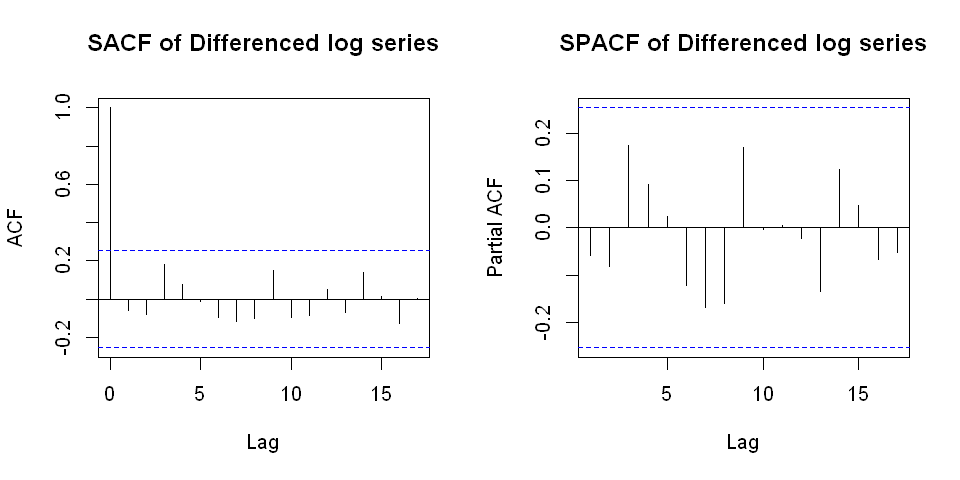

In [7]:
#differencing of the data
z <- diff(y)

plot(z, type = 'o', ylab = 'Differenced Log series')
ma15<-filter(z,sides=2,rep(1,15)/15); lines(ma15, col = 'red')
par(mfrow = c(1,2))
acf(z, main = 'SACF of Differenced log series'); pacf(z, main = 'SPACF of Differenced log series')

The series now looks a bit more stationary comparing to the original log series and the ACF decays rapidly. However, there are still some outliners in the plot. We will take another test on the differenced series to see if further differencing is need for the series. Again,

\begin{split}
H_0 & : \phi = 1 \text{ (Differencing needed)}\\
H_1 & : \phi \neq 1 \text{ (Differencing not needed)}
\end{split}

In [8]:
z <- diff(y)
adf.test(z)


	Augmented Dickey-Fuller Test

data:  z
Dickey-Fuller = -2.8941, Lag order = 3, p-value = 0.2135
alternative hypothesis: stationary


The test shows that the p-value of $H_0$ is $0.2135>0.05$. It actually suggests that we fail again to reject $H_0$ again at $5\%$ significance level. Therefore, we conclude that unit root exists in differenced log series. Now, lets take a look at the second differenced series:

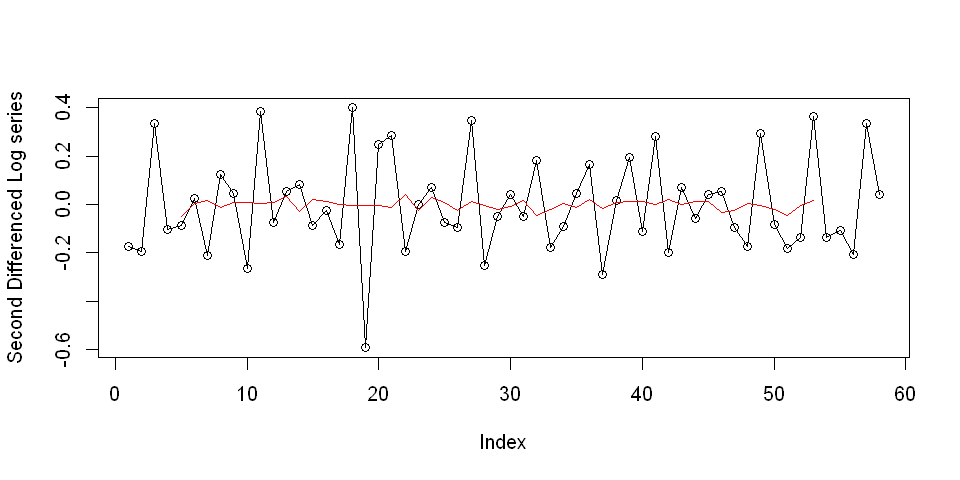

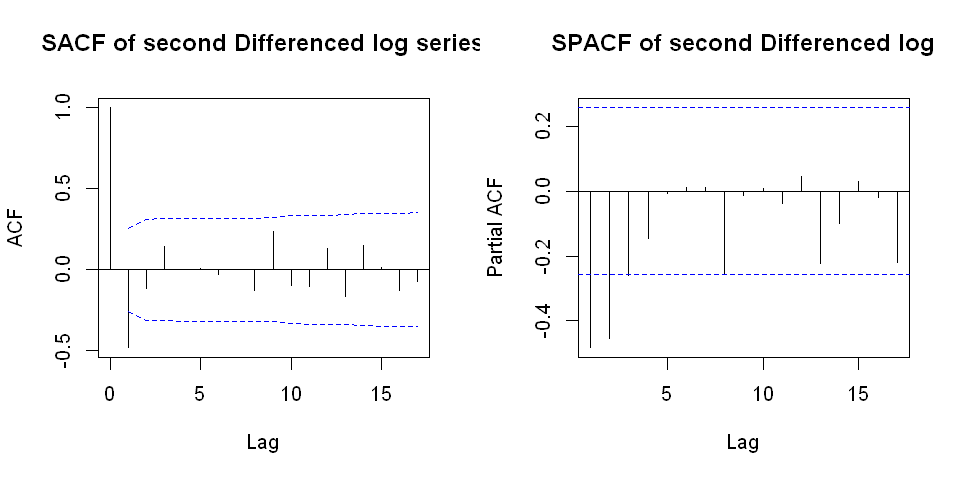

In [9]:
w <- diff(z); plot(w, type = 'o', ylab = 'Second Differenced Log series')
ma15<-filter(w,sides=2,rep(1,10)/10); lines(ma15, col = 'red')
par(mfrow = c(1:2))
acf(w, ci.type = 'ma', main = 'SACF of second Differenced log series'); pacf(w, main = 'SPACF of second Differenced log')

It now looks pretty stationary and the SACP decays rapidly. Just to be sure, I will take another quick test on it.

In [10]:
adf.test(w)

Warning message in adf.test(w):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  w
Dickey-Fuller = -6.2616, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary


This time it shows that no more differencing is needed. 

# Model fitting

The plot shows a pretty stationary mean at 0. The SACF shows a 'cut-off' and SPACF shows a 'tail-off'. It suggests that the series follows a MA(1) model. To be sure, we will take a EACF test.

In [11]:
# eacf is not defined and the following code is programmed by K.S. Chan, Department of Statistics and Actuarial Science, University of Iowa.
eacf <-
  function (z,ar.max=7,ma.max=13) 
  {   
    lag1<-function(z,lag=1){c(rep(NA,lag),z[1:(length(z)-lag)])}
    reupm<-function(m1,nrow,ncol){
      k<-ncol-1
      m2<-NULL
      for (i in 1:k){
        i1<-i+1
        work<-lag1(m1[,i])
        work[1]<--1
        temp<-m1[,i1]-work*m1[i1,i1]/m1[i,i]
        temp[i1]<-0
        m2<-cbind(m2,temp)
      }
      m2}
    ceascf<-function(m,cov1,nar,ncol,count,ncov,z,zm){
      result<-0*seq(1,nar+1)
      result[1]<-cov1[ncov+count]
      for (i in 1:nar) {
        temp<-cbind(z[-(1:i)],zm[-(1:i),1:i])%*%c(1,-m[1:i,i])
        result[i+1]<-acf(temp,plot=FALSE,lag.max=count,drop.lag.0=FALSE)$acf[count+1]
      }
      result
    }
      
    ar.max<-ar.max+1
    ma.max<-ma.max+1
    nar<-ar.max-1
    nma<-ma.max
    ncov<-nar+nma+2
    nrow<-nar+nma+1
    ncol<-nrow-1
    z<-z-mean(z)
    zm<-NULL
    for(i in 1:nar) zm<-cbind(zm,lag1(z,lag=i))
    cov1<-acf(z,lag.max=ncov,plot=FALSE,drop.lag.0=FALSE)$acf
    cov1<-c(rev(cov1[-1]),cov1)
    ncov<-ncov+1
    m1<-matrix(0,ncol=ncol,nrow=nrow)
    for(i in 1:ncol) m1[1:i,i]<-
      ar.ols(z,order.max=i,aic=FALSE,demean=FALSE,intercept=FALSE)$ar
    eacfm<-NULL
    for (i in 1:nma) {
      m2<-reupm(m1=m1,nrow=nrow,ncol=ncol)
      ncol<-ncol-1
      eacfm<-cbind(eacfm, ceascf(m2,cov1,nar,ncol,i,ncov,z,zm))
      m1<-m2}
    work<-1:(nar+1)
    work<-length(z)-work+1
    symbol<-NULL
    for ( i in 1:nma) {
      work<-work-1
      symbol<-cbind(symbol,ifelse(abs(eacfm[,i])>2/work^.5, 'x','o'))}
    rownames(symbol)<-0:(ar.max-1)
    colnames(symbol)<-0:(ma.max-1)
    cat('AR/MA\n')
    print(symbol,quote=FALSE)
    invisible(list(eacf=eacfm,ar.max=ar.max,ma.ma=ma.max,symbol=symbol))
  }
eacf(w)

AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 x o o o o o o o o o o  o  o  o 
1 x x o o o o o o o o o  o  o  o 
2 x o o o o o o o o o o  o  o  o 
3 x o o o o o o o o o o  o  o  o 
4 o o o o o o o o o o o  o  o  o 
5 x o o o o o o o o o o  o  o  o 
6 x o o o o o o o o o o  o  o  o 
7 o o o x x o o o o o o  o  o  o 


By the principle, the SEACF table also suggests that a MA(1) model. Therefore, we will try fitting one. 

In [12]:
#fitting a ARIMA(0,2,1) model to the data
fitMA1mle <- arima(y, order=c(0,2,1), include.mean = FALSE, method = 'ML')

fitMA1mle


Call:
arima(x = y, order = c(0, 2, 1), include.mean = FALSE, method = "ML")

Coefficients:
          ma1
      -0.9482
s.e.   0.0625

sigma^2 estimated as 0.01962:  log likelihood = 30.57,  aic = -57.13

Before we lay out the model we will have a diagnostic checking on the model.

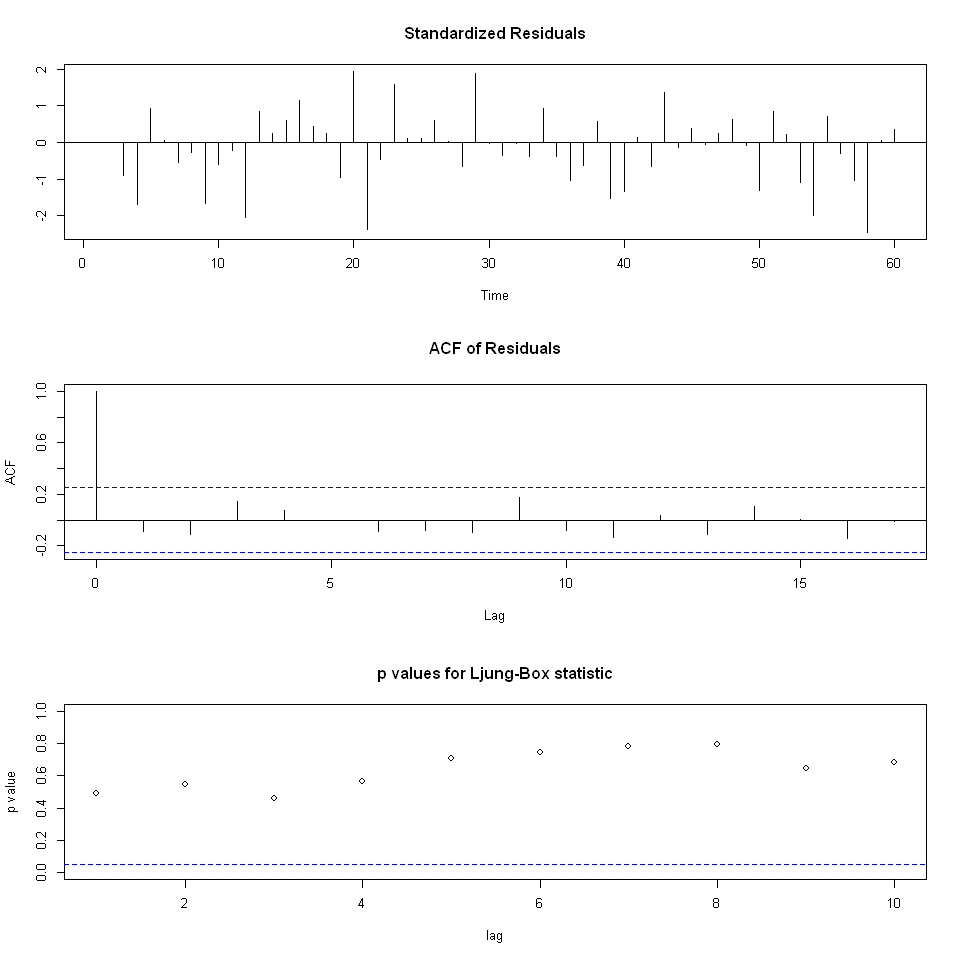

In [13]:
options(repr.plot.width=8, repr.plot.height=8)

#3 diagnostic plots of the model
tsdiag(fitMA1mle,golf.lag=25)

In the first plot, it shows that the standardized error is quite random. However, there are a few points which has a variance of 2 or -2. Therefore, I won't be too sure about a constant variance. In the second plot (SACF of residuals), it shows that no points are out of or even close to the blue dashed line. Therefore, by the criteria, we fail to reject and we accept the hypothesis that the rescaled residuals are similar to a iid noise. In the third plot, without bringing out the statistic, we can clearly see that the p-value for the Lyung-Box statistic at each lag is way bigger than 0.05. Therefore, at $5\%$ significiant level, we fail to reject the null hypothesis

\begin{equation}
H_0:\rho_1 = \rho_2 = \dots = \rho_{10} = 0
\end{equation}

and it suggests that there is no correlation at lag $1,2, \dots, 10$, and the residuals are iid white noise. This fitted model is actually quite good for the data. The model we fitted is as follows:

\begin{split}
y_t &\sim \text{ARIMA}(0,2,1) \\
\bigtriangledown^2 y_t & = W_t - 0.9482 W_{t-1} \\
(1-2B+B^2)y_t & = W_t - 0.9482 W_{t-1} \\
y_t - 2 y_{t-1} + y_{t-2} & = W_t - 0.9482 W_{t-1} \\
y_t & = 2 y_{t-1} - y_{t-2} + W_t - 0.9482 W_{t-1} \\
\end{split}

where $W_t \sim \text{WN}(0,0.0625)$ and $y_t$ is the log series of the original data. 

# Forecast

Next, we wish to make predictions on the 3 months and 2 year subscriptions, and the results are as follows:

In [14]:
#forecasts of the next 3 months
forecast <-predict(fitMA1mle,3)

#upper and lower bound of the 3 months forecasts
u <- forecast$pred+1.96*forecast$se
l <- forecast$pred-1.96*forecast$se

#putting the data in a table
pred_table <- data.frame(rbind(exp(forecast$pred), exp(l),exp(u)))
rownames(pred_table) <- c('prediction', 'lower bound', 'upper bound')
colnames(pred_table) <- c('Month 61', 'Month 62', 'Month 63')

pred_table

,Month 61,Month 62,Month 63
prediction,12.28961,12.158853,12.029485
lower bound,9.33917,8.162802,7.291677
upper bound,16.17216,18.111147,19.845711


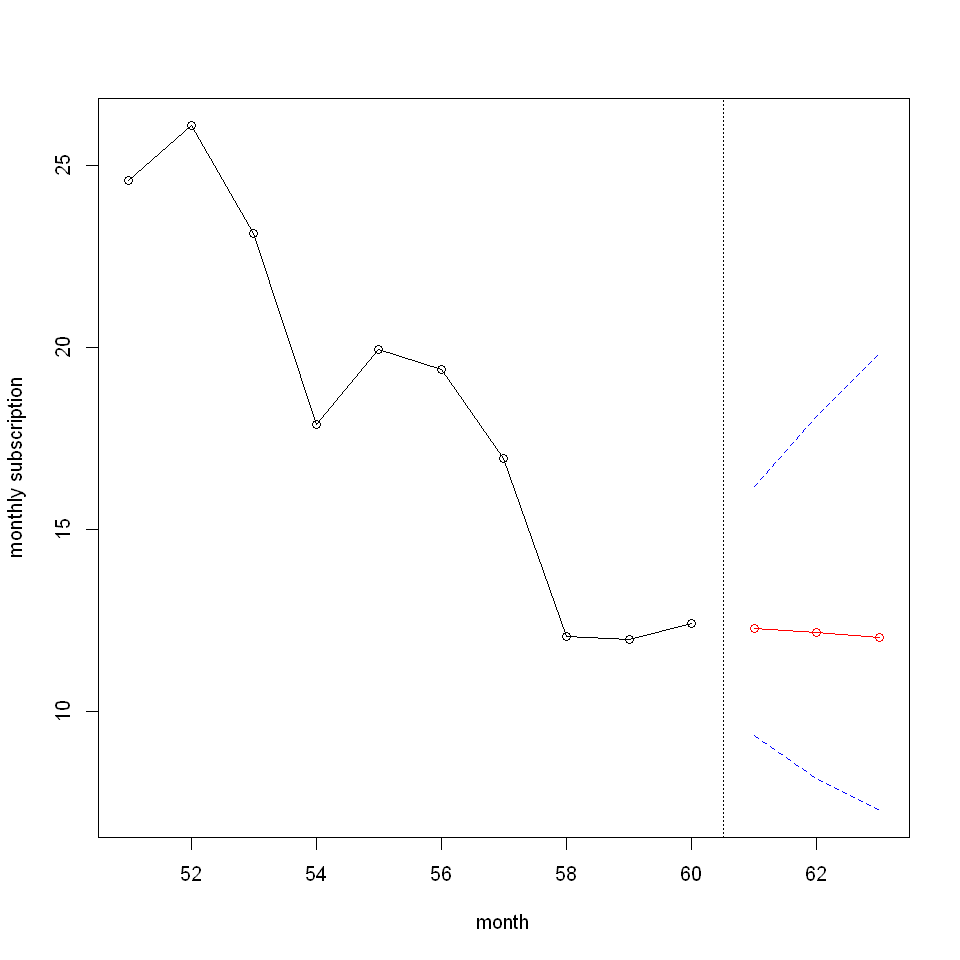

In [15]:
#plot of the monlthy subscription from month 51 to 60 and the forecasts of the next 3 months
month <- seq(51,60)
monthforecast <- seq(61,63)
plot(month,mem_sub[month],type='o',xlim=c(51,63),ylim=c(min(exp(l), mem_sub[51:60]),max(mem_sub[51:60],exp(u))), ylab='monthly subscription')
lines(monthforecast, exp(forecast$pred), col = 'red', type = 'o')
lines(monthforecast, exp(u), col = 'blue', lty = 'dashed')
lines(monthforecast, exp(l), col = 'blue', lty = 'dashed')
abline(v = 60+0.5, lty = 'dotted')

The forecasting of the first 3 months are all close to \$12 millions, but it is slightly decreasing each month. 

In [16]:
# forecasts of the next 2 years
forecast <-predict(fitMA1mle,24)
forecast <-predict(fitMA1mle,24)
u <- forecast$pred+1.96*forecast$se
l <- forecast$pred-1.96*forecast$se
pred_table <- data.frame(rbind(exp(forecast$pred), exp(l),exp(u)))
rownames(pred_table) <- c('prediction', 'lower bound', 'upper bound')
colnames(pred_table) <- c('Month 61', 'Month 62', 'Month 63', 'Month 64', 'Month 65', 'Month 66', 'Month 67', 'Month 68', 'Month 69', 'Month 70', 'Month 71', 'Month 72', 'Month 73', 'Month 74', 'Month 75', 'Month 76', 'Month 77', 'Month 78', 'Month 79', 'Month 80', 'Month 81', 'Month 82', 'Month 83', 'Month 84')
pred_table

,Month 61,Month 62,Month 63,Month 64,Month 65,Month 66,Month 67,Month 68,Month 69,Month 70,...,Month 75,Month 76,Month 77,Month 78,Month 79,Month 80,Month 81,Month 82,Month 83,Month 84
prediction,12.28961,12.158853,12.029485,11.901493,11.774863,11.649581,11.525631,11.403000,11.281674,11.161639,...,10.580351,10.467778,10.356402,10.246212,10.137194,10.029336,9.922625,9.81705,9.712598,9.609258
lower bound,9.33917,8.162802,7.291677,6.579371,5.970317,5.436435,4.961194,4.533848,4.146902,3.794839,...,2.434736,2.225846,2.033865,1.857428,1.695304,1.546374,1.409618,1.28410,1.168960,1.063402
upper bound,16.17216,18.111147,19.845711,21.528736,23.222787,24.963551,26.775849,28.679485,30.691865,32.829374,...,45.977800,49.228196,52.734598,56.521618,60.616102,65.047398,69.847653,75.05213,80.699555,86.832519


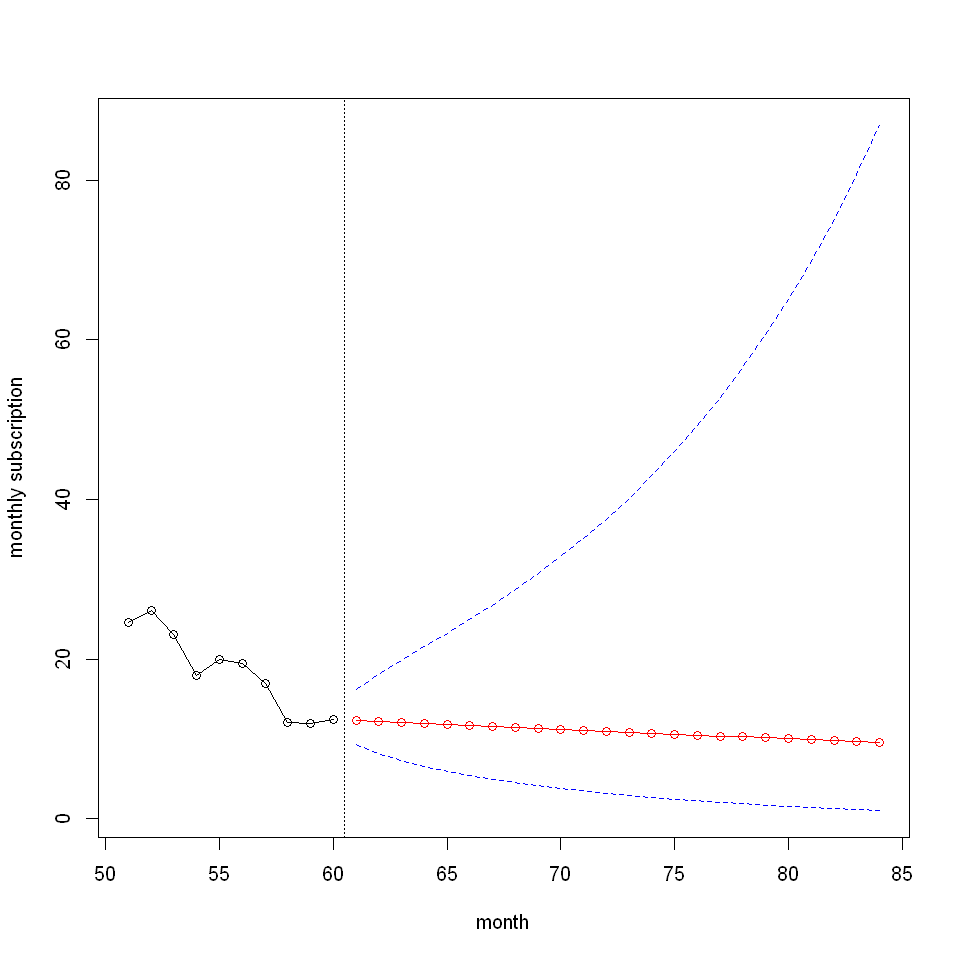

In [17]:
#plot of the monlthy subscription from month 51 to 60 and the forecasts of the next 2 years.
month <- seq(51,60)
monthforecast <- seq(61,84)
plot(month,mem_sub[month],type='o',xlim=c(51,84),ylim=c(min(exp(l), mem_sub[51:60]),max(mem_sub[51:60],exp(u))), ylab='monthly subscription')
lines(monthforecast, exp(forecast$pred), col = 'red', type = 'o')
lines(monthforecast, exp(u), col = 'blue', lty = 'dashed')
lines(monthforecast, exp(l), col = 'blue', lty = 'dashed')
abline(v = 60+0.5, lty = 'dotted')

From the table and the graph, it suggests that the monthly subscriptions keeps reducing at a linear amount, and it keeps dropping to $9$ million after 2 years. Notice that the prediction interval keeps growing bigger and bigger each month.

By the nature of time-series analysis, the long term forecasting is usually not accurate at all, and it is reflected by the growing interval provided in the graph. We can see that at the $84$th month (2 years from now), the $95\%$ interval is very large (1.06, 86.83). This is usually due to the future being more and more unpredictable. However, notice that the area of upper bound of the prediction is way bigger than the area of lower bound of the prediction. This suggests that the monthly subscription is more likely to move up than down.

Therefore, I can only conclude that given the data of 5 year member subscriptions, the forecast of the member subscriptions next month is in the interval $[9.34, 16.17]$, and the prediction is $\$ 12.29$ million. 